In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-loan-approval/loan_sanction_test.csv
/kaggle/input/home-loan-approval/loan_sanction_train.csv


# Get The Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder , StandardScaler
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Set the theme for seaborn
sns.set_theme()

# Suppress warnings
warnings.filterwarnings('ignore')

# Get The Data

In [3]:
data = pd.read_csv("/kaggle/input/home-loan-approval/loan_sanction_train.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
data.describe(include="O")

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


# EDA & Some Cleaning

In [7]:
#Check Duplicated Values
data.duplicated().sum()

0

In [8]:
#Check Null VALUES
data.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

* We will handle that in Preprocessing

In [9]:
#Check Number Of Unique Cat Values
data.select_dtypes('object').nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

* The Loan_ID col we willn't Need it In Predicition So we will drop it

In [10]:
# Drop Loan_ID col
data.drop(["Loan_ID"], axis=1, inplace=True)

In [11]:
#Check Number Of Unique Num Values
data.select_dtypes('number').nunique()

ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
dtype: int64

In [12]:
data["Loan_Amount_Term"].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

In [13]:
data["Credit_History"].value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

* Loan_Amount_Term & 
Credit_Histor columns Have al low Unique Values so we will make them Cat Features to be usefuly

In [14]:
#Make Loan_Amount_Term & Credit_History columns as Categorical columns
data["Loan_Amount_Term"] = data["Loan_Amount_Term"].astype("object")
data["Credit_History"] = data["Credit_History"].astype("object")

* Now we need also to make The Loan_Status column as binary (0,1) To be Y Predicition in our Model
* Also It's Recommended to make Credit_History Col as (Yes,No) to make more Understood

In [15]:
# mapping target values for the Predicition and the visualization in bivariate analysis
data['Loan_Status'] = data['Loan_Status'].map({'Y':1,'N':0})

# Credit History as (Yes,No)
data['Credit_History'] = data['Credit_History'].map({1:'Yes', 0:'No'})

In [16]:
data.sample(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
29,Female,No,2,Graduate,NaN,3750,2083.0,120.0,360.0,Yes,Semiurban,1
111,Female,Yes,0,Graduate,NaN,2929,2333.0,139.0,360.0,Yes,Semiurban,1
604,Female,Yes,1,Graduate,No,12000,0.0,496.0,360.0,Yes,Semiurban,1
557,Male,Yes,3+,Graduate,Yes,10139,0.0,260.0,360.0,Yes,Semiurban,1
270,Female,No,0,Graduate,No,3237,0.0,30.0,360.0,Yes,Urban,1


## Univarite Analysis

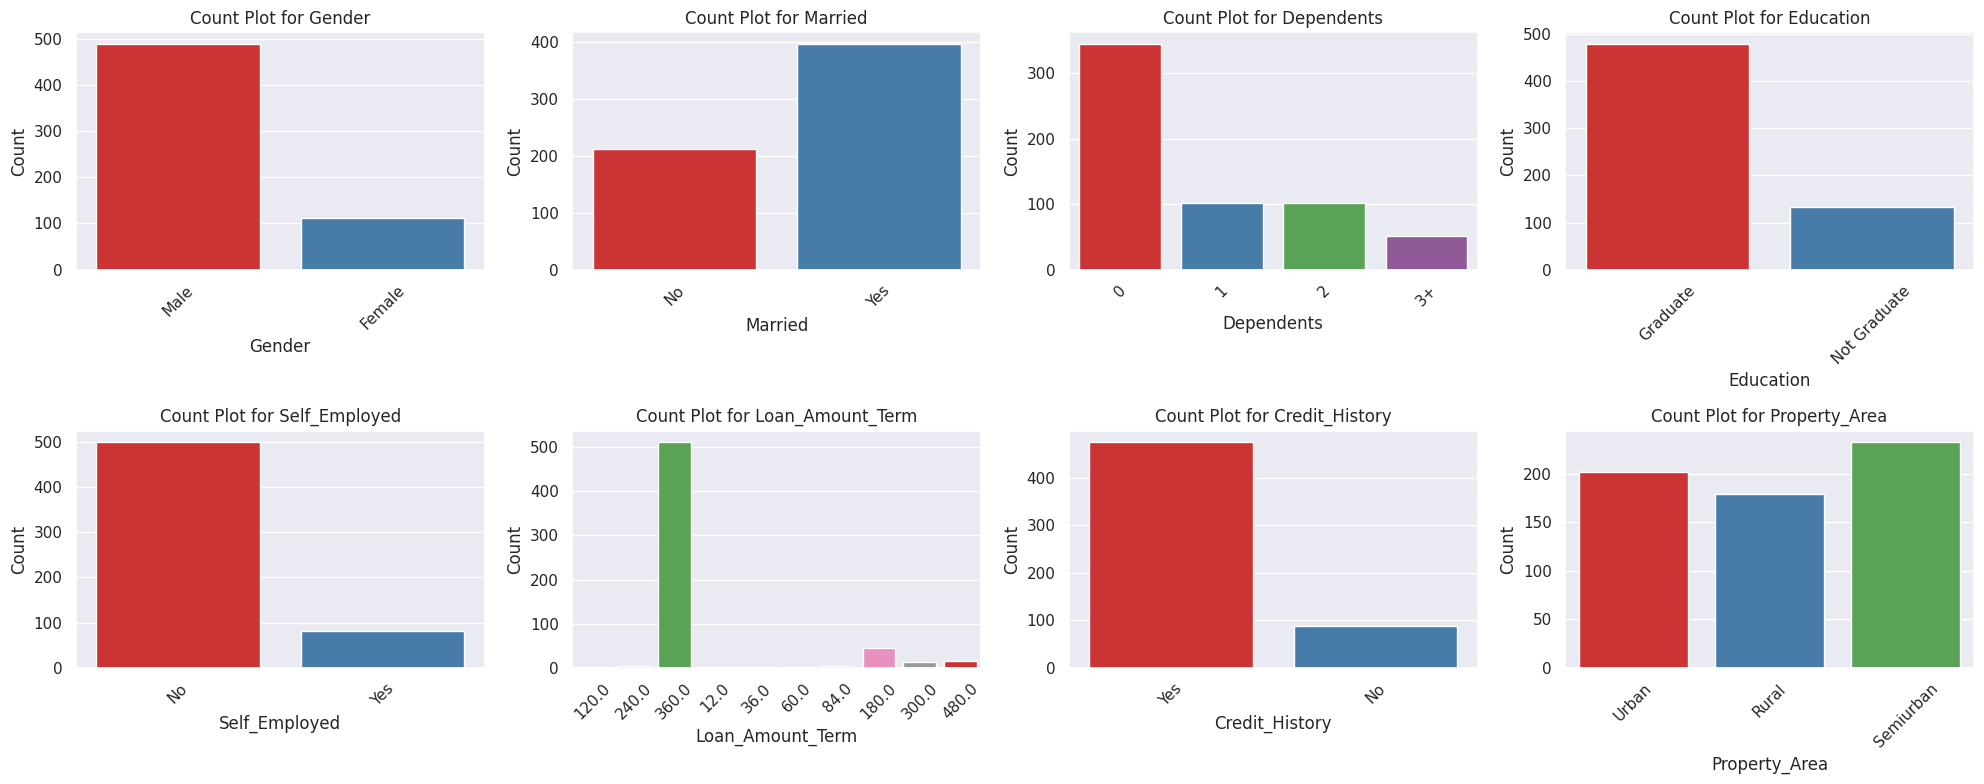

In [17]:
# List of categorical columns to visualize
cat_cols = data.select_dtypes('object').columns.tolist()

# Set up the subplot grid dimensions
n_cols = 4
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop through each categorical column and create a subplot
for i, column_name in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data, x=column_name, palette="Set1")
    plt.title(f'Count Plot for {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Notes:
* Most Gender Apply On a home loan is "Male"
* The most Are Married.
* The most of the applicants have no dependents.
* The most Are Graduated.
* The most of the applicants Are Self Employed.
* The most of the loans are 360.
* The most are have the Credit History.
* The Most Are Semiurban

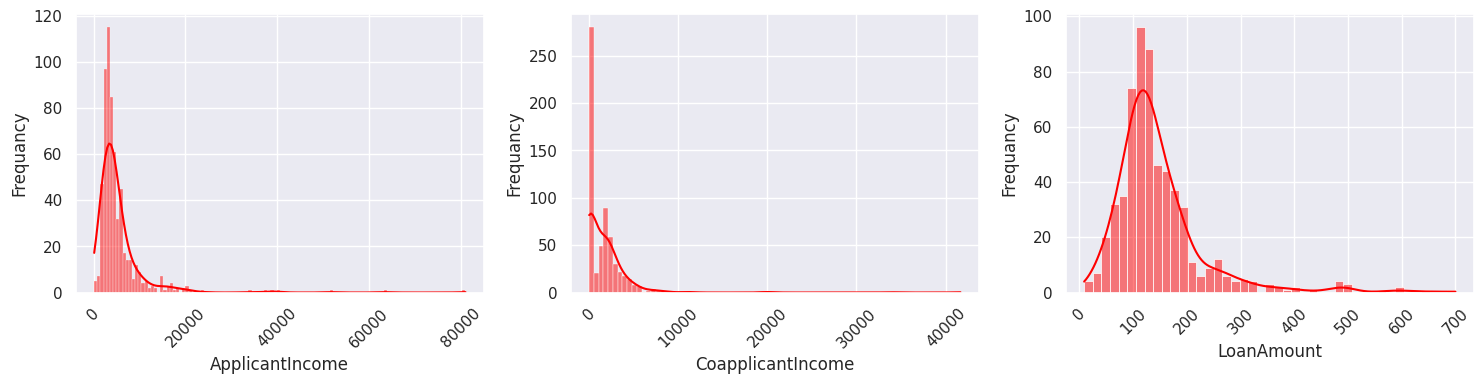

In [18]:
# List of categorical columns to visualize
num_cols = data.select_dtypes('number').columns.tolist()
if "Loan_Status" in num_cols:
    num_cols.remove("Loan_Status")
    
# Set up the subplot grid dimensions
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop through each categorical column and create a subplot
for i, column_name in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=data, x=column_name, kde=True , color="red")
    plt.ylabel('Frequancy')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

***I think There are of Outilers***

### Outliers Handling

* We need to Hnadle That For be Useful In Bivariate Analysis and also we need them Clean the Model Training

In [19]:
data.select_dtypes('number').quantile([0.001 , 0.01 , 0.1, 0.3, 0.5, 0.75, 0.9, 0.99 , 0.999 , 1])

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Status
0.001,186.780,0.00,13.728,0.0
0.010,1025.000,0.00,30.000,0.0
0.100,2216.100,0.00,71.000,0.0
0.300,3050.400,0.00,108.000,0.0
0.500,3812.500,1188.50,128.000,1.0
0.750,5795.000,2297.25,168.000,1.0
0.900,9459.900,3782.20,235.800,1.0
0.990,32540.410,8895.89,496.360,1.0
0.999,70172.581,36867.21,670.450,1.0
1.000,81000.000,41667.00,700.000,1.0


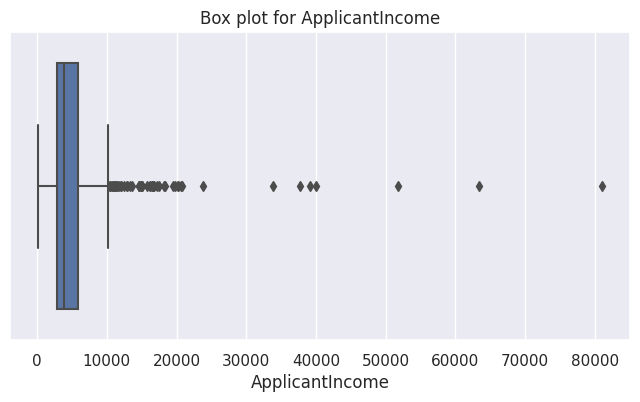

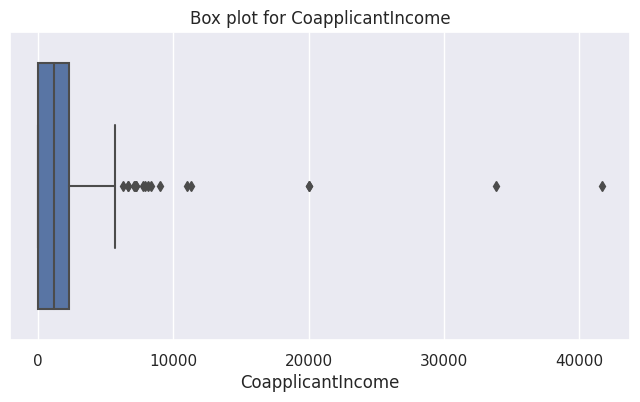

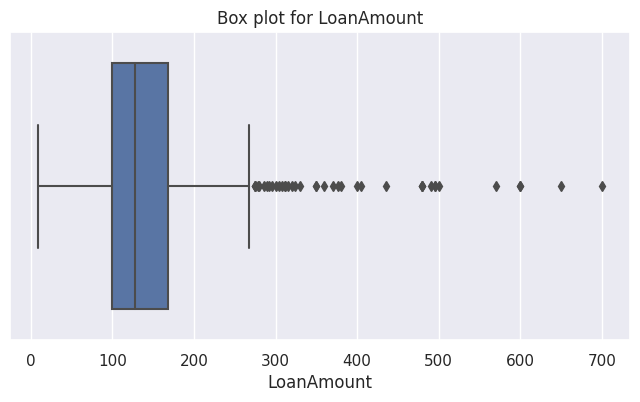

In [20]:
num_cols = data.select_dtypes(include=['number']).columns.tolist()
if "Loan_Status" in num_cols:
    num_cols.remove("Loan_Status")

# Plot a box plot for each numeric column
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data, x=col)
    plt.title(f'Box plot for {col}')
    plt.show()

In [21]:
data = data[data['CoapplicantIncome']<12000]
data = data[data['ApplicantIncome']<40000]

data["LoanAmount"] = data["LoanAmount"].apply(np.log1p)
data["ApplicantIncome"] = data["ApplicantIncome"].apply(np.log1p)

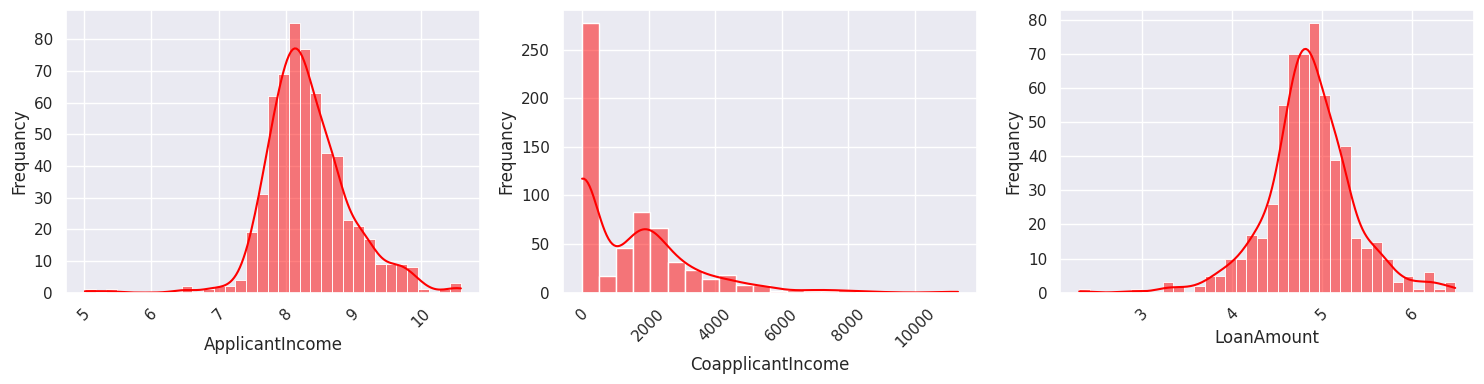

In [22]:
# List of categorical columns to visualize
num_cols = data.select_dtypes('number').columns.tolist()
if "Loan_Status" in num_cols:
    num_cols.remove("Loan_Status")
    
# Set up the subplot grid dimensions
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop through each categorical column and create a subplot
for i, column_name in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=data, x=column_name, kde=True , color="red")
    plt.ylabel('Frequancy')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

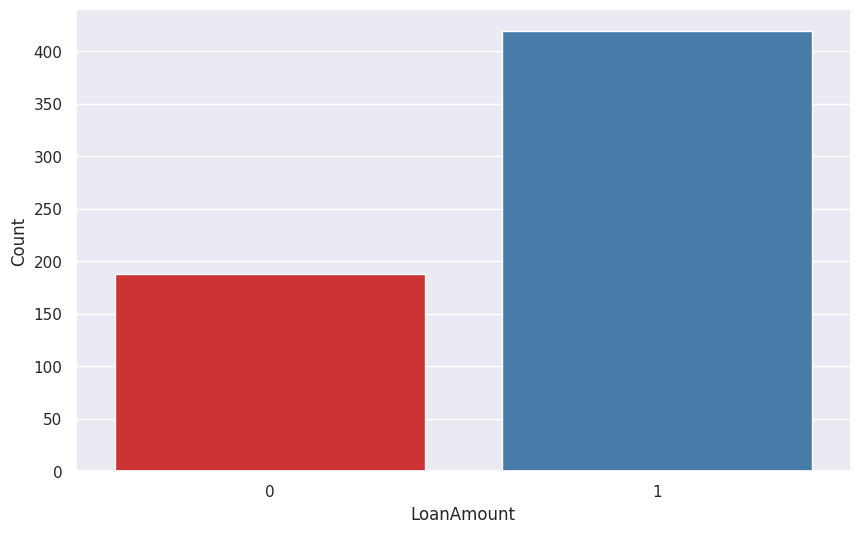

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="Loan_Status", palette="Set1")
plt.xlabel(column_name)
plt.ylabel('Count')
plt.show()

* The most are Accepted In loan Home

## Bivariate Analysis

* We need to see How the columns Affect On Loan_Status

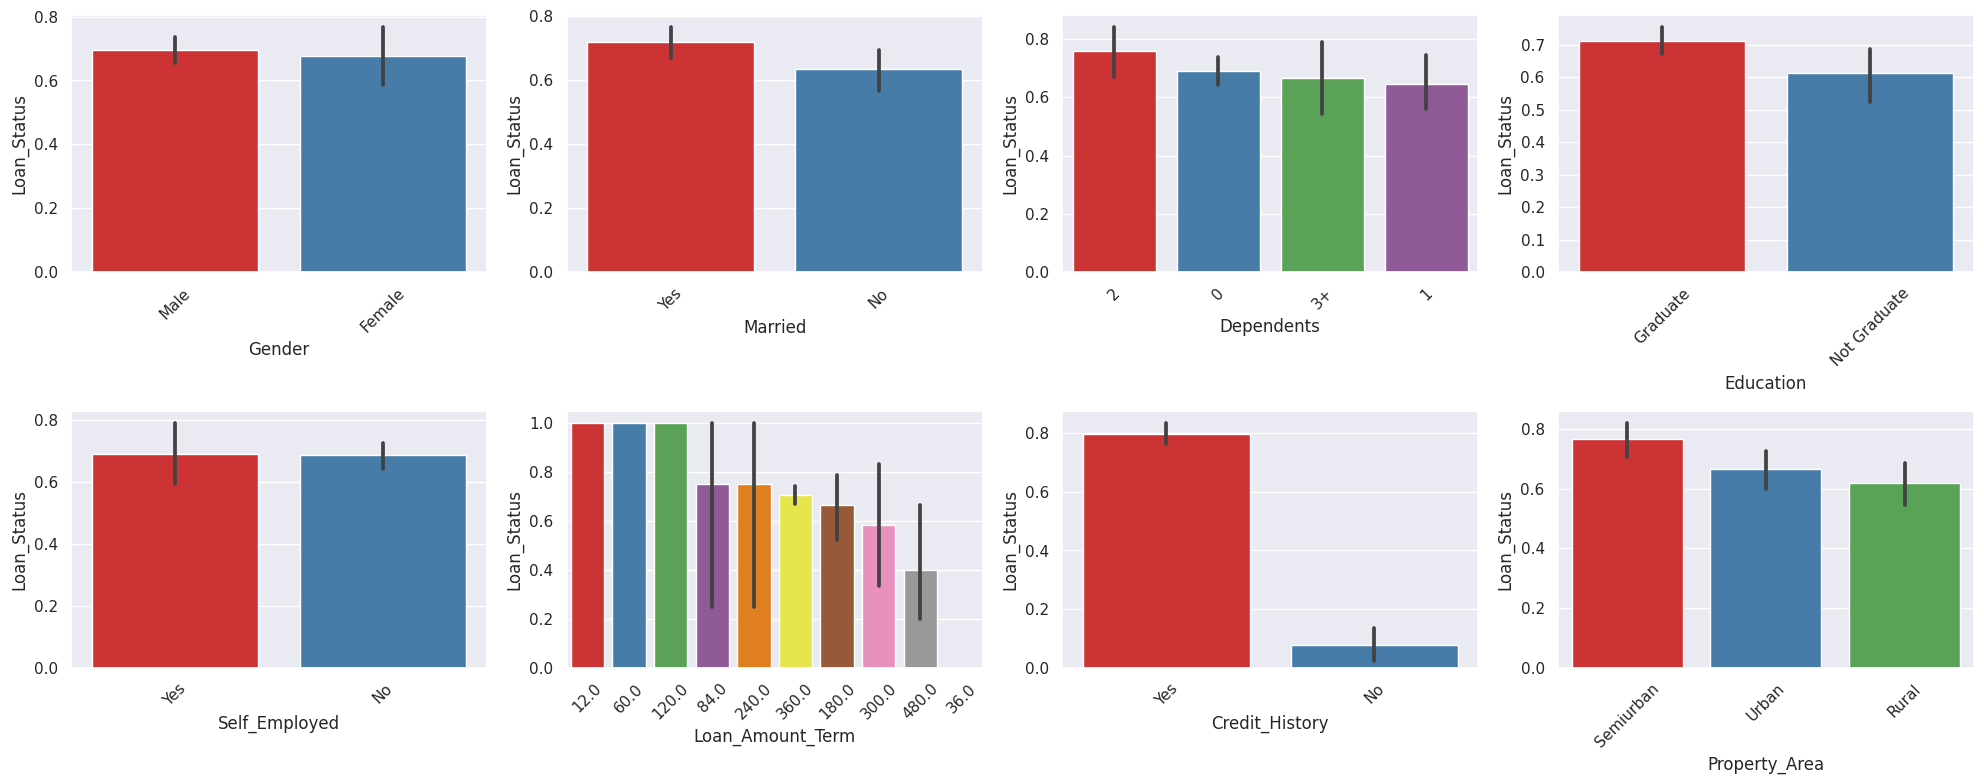

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical columns to visualize along with 'Loan_Status'
cat_cols = data.select_dtypes('object').columns.tolist()

# Set up the subplot grid dimensions
n_cols = 4
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop through each categorical column and create a subplot
for i, column_name in enumerate(cat_cols, 1):
    order = data.groupby(column_name)["Loan_Status"].mean().sort_values(ascending=False).index
    plt.subplot(n_rows, n_cols, i)
    sns.barplot(data=data, x=column_name,y='Loan_Status' ,order=order , palette="Set1")
    plt.xlabel(column_name)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* The Credit_History Has A Strong Affect ON the Loan_Status
* The Loan_Amount_Term & Propert_Area & Dependents have a normal Affect
* The Gender & Married & Education & Self-Employed have a Very Low Affect

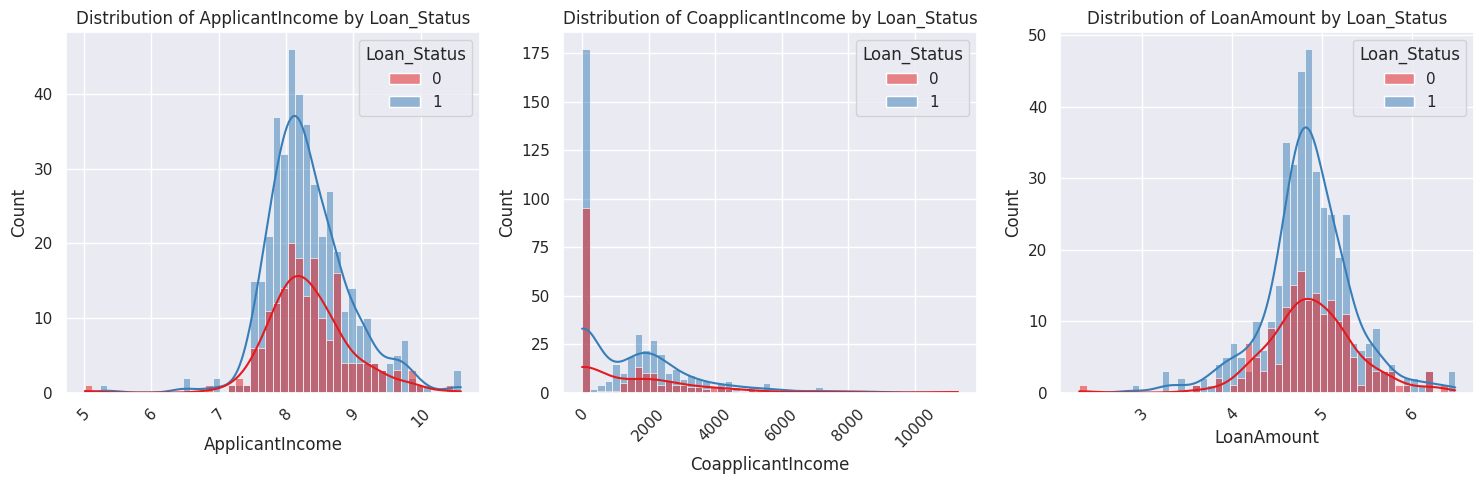

In [25]:
# List of numeric columns to visualize along with 'Loan_Status'
num_cols = data.select_dtypes('number').columns.tolist()
if "Loan_Status" in num_cols:
    num_cols.remove("Loan_Status")
    
# Set up the subplot grid dimensions
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 5))

# Loop through each numeric column and create a subplot
for i, column_name in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=data, x=column_name, hue="Loan_Status", palette="Set1", bins=50 , kde=True)
    plt.title(f'Distribution of {column_name} by Loan_Status')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Correlition

In [26]:
data.select_dtypes(include='number').corr().abs()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Status
ApplicantIncome,1.000000,0.177451,0.500119,0.001363
CoapplicantIncome,0.177451,1.000000,0.296972,0.015080
LoanAmount,0.500119,0.296972,1.000000,0.035115
Loan_Status,0.001363,0.015080,0.035115,1.000000


<Axes: >

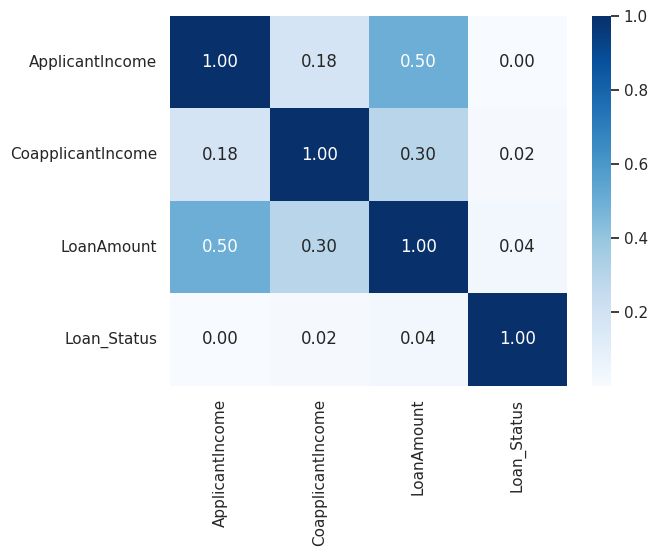

In [27]:
sns.heatmap(data.select_dtypes(include='number').corr().abs(), annot=True, cmap="Blues", fmt=".2f", cbar=True)

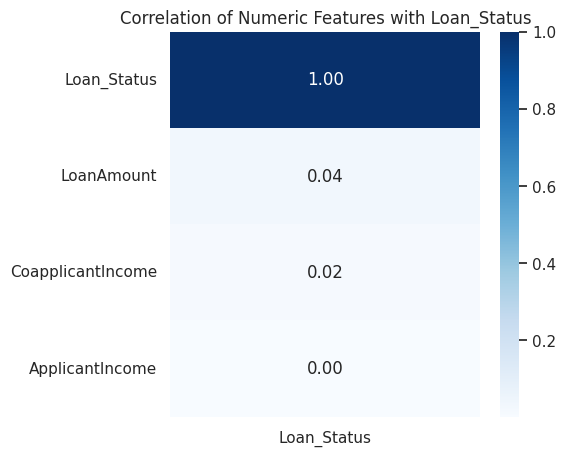

In [28]:
# Calculate the correlation of numeric columns with 'Loan_Status' and reshape for heatmap
loan_status_corr = data.select_dtypes(include='number').corr()['Loan_Status'].abs().sort_values(ascending=False).to_frame()

# Plot heatmap
plt.figure(figsize=(5,5))
sns.heatmap(loan_status_corr, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("Correlation of Numeric Features with Loan_Status")
plt.show()

# Data Splitting and Preprocessing

In [29]:
# Define features and target
x = data.drop(["Loan_Status"], axis=1)
y = data["Loan_Status"]

# Separate numeric and categorical features
num_ftrs = x.select_dtypes(include='number').columns.tolist()
cat_ftrs = x.select_dtypes(include='object').columns.tolist()

In [30]:
# Split the data into training and testing sets (e.g., 80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("Training feature set:", x_train.shape)
print("Testing feature set:", x_test.shape)
print("Training target set:", y_train.shape)
print("Testing target set:", y_test.shape)

Training feature set: (485, 11)
Testing feature set: (122, 11)
Training target set: (485,)
Testing target set: (122,)


In [31]:
num_pipeline = make_pipeline(SimpleImputer(),
                            StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder())

preprocessor = ColumnTransformer(transformers=[ ("num", num_pipeline, num_ftrs),
                                                ("cat", cat_pipeline, cat_ftrs)])

train = preprocessor.fit_transform(x_train)
test = preprocessor.transform(x_test)

# Modeling

## Logistic Regression

In [32]:
# Initialize and train the logistic regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(train, y_train)  # Fit with training data (features and labels)

LogisticRegression(random_state=42)

In [33]:
# To make predictions on the test set:
y_pred_prob = log_reg.predict_proba(train)[:, 1]  
y_pred_train = (y_pred_prob >= 0.5).astype(int)  

accuracy_train = accuracy_score(y_train, y_pred_train)

print(f'Accuracy Training: {accuracy_train * 100:.2f}%')

Accuracy Training: 81.86%


* Now lets try The confusion Matrix

In [34]:
# Generate the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)
cm

array([[ 71,  81],
       [  7, 326]])

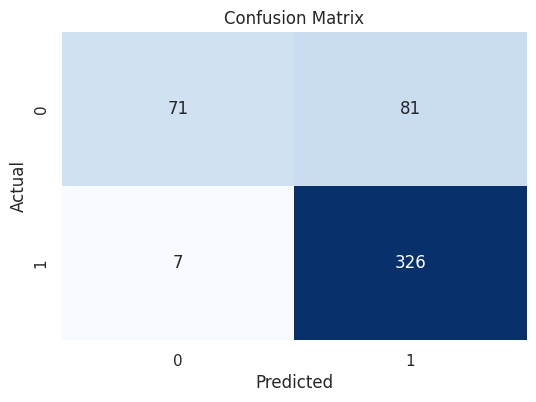

In [35]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True , fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [36]:
# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.47      0.62       152
           1       0.80      0.98      0.88       333

    accuracy                           0.82       485
   macro avg       0.86      0.72      0.75       485
weighted avg       0.84      0.82      0.80       485



In [37]:
# Define the parameter grid for penalty and C
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': [0.01, 0.1, 1, 10, 100],
              'solver': ['saga', 'liblinear']}

grid_search = GridSearchCV(log_reg, param_grid, cv=5 , scoring="f1")

# Fit GridSearchCV on the training data
grid_search.fit(train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['saga', 'liblinear']},
             scoring='f1')

In [38]:
# best parameters
grid_search.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

In [39]:
log_reg = LogisticRegression(**grid_search.best_params_ , random_state=42)
log_reg.fit(train, y_train)
y_pred_prob = log_reg.predict_proba(train)[:, 1]  
y_pred_train = (y_pred_prob >= 0.5).astype(int)  
confusion_matrix(y_train, y_pred_train)

array([[ 73,  79],
       [  7, 326]])

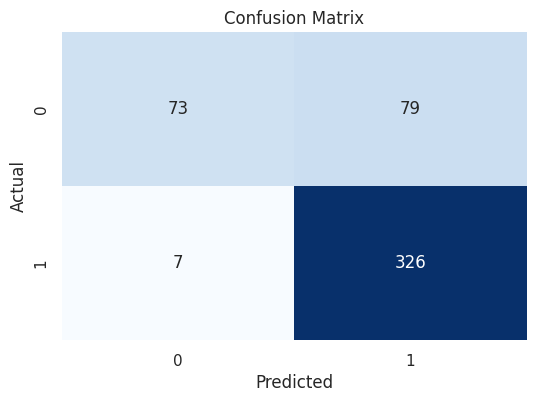

In [40]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True , fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [41]:
# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_train, y_pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.48      0.63       152
           1       0.80      0.98      0.88       333

    accuracy                           0.82       485
   macro avg       0.86      0.73      0.76       485
weighted avg       0.84      0.82      0.80       485



* Now let's Use Precision-Recall Curve to use best Threshold to perform(More FN , Less FP) , (More Precision , Less Recall)

In [42]:
# Get predicted probabilities for the positive class
y_pred = log_reg.predict_proba(train)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)

df = pd.DataFrame({"Threshold": thresholds, "Precision": precision[:-1], "Recall": recall[:-1]})

# Display the DataFrame
df.sample(10)

,Threshold,Precision,Recall
23,0.051452,0.718615,0.996997
98,0.618753,0.811370,0.942943
333,0.846929,0.907895,0.414414
81,0.506515,0.804455,0.975976
256,0.792262,0.886463,0.609610
24,0.052762,0.720174,0.996997
220,0.766974,0.875472,0.696697
476,0.944096,0.888889,0.024024
65,0.134976,0.783333,0.987988
68,0.183661,0.786571,0.984985


In [43]:
# Create a line plot for Precision vs Recall
px.line(df, x="Recall", y="Precision", title="Precision vs Recall", hover_data=["Threshold"] ,markers=True)

In [44]:
# Find the best threshold where precision is high and recall is relatively lower
for p, r, t in zip(precision, recall, thresholds):
    if p >= 0.85:
        print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")
        break

Threshold: 0.75, Precision: 0.85, Recall: 0.74


* Now Lets Check

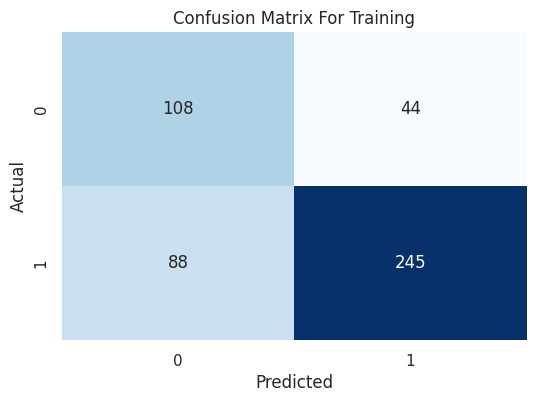

In [45]:
y_pred_train = (y_pred_prob >= 0.75).astype(int)  
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True , fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix For Training")
plt.show()

In [46]:
# Generate and print the classification report
print("Classification Report For Training:")
print(classification_report(y_train, y_pred_train))

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       152
           1       0.85      0.74      0.79       333

    accuracy                           0.73       485
   macro avg       0.70      0.72      0.70       485
weighted avg       0.75      0.73      0.74       485



Testing

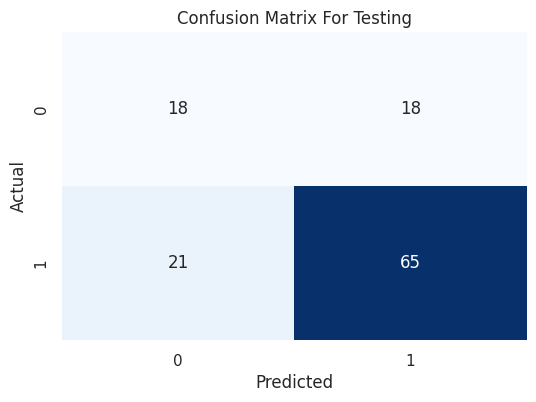

In [47]:
# To make predictions on the test set:
y_pred_prob = log_reg.predict_proba(test)[:, 1]  
y_pred_test = (y_pred_prob >= 0.75).astype(int)  
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True , fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix For Testing")
plt.show()

In [48]:
# Generate and print the classification report
print("Classification Report For Testing:")
print(classification_report(y_test, y_pred_test))

Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        36
           1       0.78      0.76      0.77        86

    accuracy                           0.68       122
   macro avg       0.62      0.63      0.62       122
weighted avg       0.69      0.68      0.68       122



* We Got 0.77 Accuracy By F1 Score Matrix With 0.78 Precision by Logistic Regression Model

 Now Let's Try Another Model

## Support Vector Classifier(SVC)

In [49]:
# Initialize the SVC model with poly 
svc = SVC(kernel="poly" , random_state=42)
train_svc = train.reshape(-1,1)
svc.fit(train, y_train)  # Fit with training data (features and labels)

SVC(kernel='poly', random_state=42)

In [50]:
# To make predictions on the training set
y_pred = svc.predict(train)

# Generate and print the classification report for training data
print("Classification Report For Training:")
print(classification_report(y_train, y_pred))

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       152
           1       0.82      0.98      0.90       333

    accuracy                           0.84       485
   macro avg       0.88      0.76      0.79       485
weighted avg       0.86      0.84      0.83       485



In [51]:
# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'] 
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='poly', random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto']},
             scoring='f1')

In [52]:
# Print best parameters and best score
grid_search.best_params_

{'C': 10, 'gamma': 'auto'}

In [53]:
# Assuming you have already performed a grid search and have the best parameters
best_params = grid_search.best_params_

# Create a new instance of SVC with probability estimation enabled
svc = SVC(**best_params, kernel= 'rbf' ,probability=True, random_state=42) 

# Fit the SVC model with training data
svc.fit(train, y_train)  # Assuming 'train' is properly shaped for SVC

SVC(C=10, gamma='auto', probability=True, random_state=42)

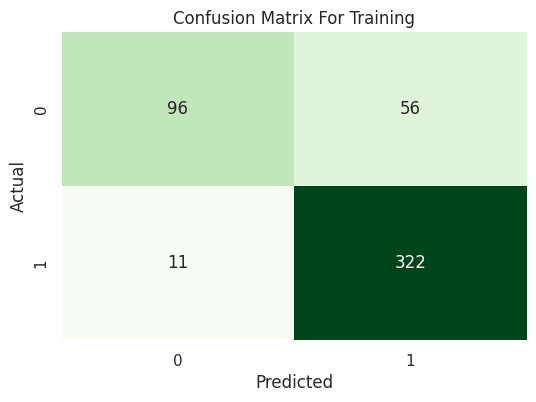

In [54]:
# Get the predicted probabilities for the training set
y_proba = svc.predict_proba(train)[:, 1]  # Get the probabilities for the positive class

# Apply the threshold of 0.75
y_pred = (y_proba >= 0.75).astype(int)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix For Training")
plt.show()

In [55]:
# Generate and print the classification report for training data
print("Classification Report For Training:")
print(classification_report(y_train, y_pred))

Classification Report For Training:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       152
           1       0.85      0.97      0.91       333

    accuracy                           0.86       485
   macro avg       0.87      0.80      0.82       485
weighted avg       0.87      0.86      0.85       485



Testing

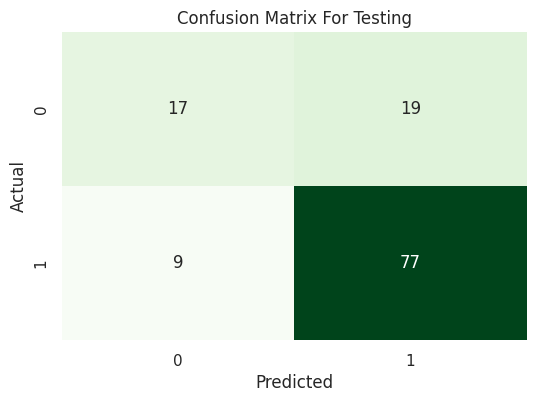

In [56]:
# Get the predicted probabilities for the training set
y_proba = svc.predict_proba(test)[:, 1]  # Get the probabilities for the positive class

# Apply the threshold of 0.75
y_pred_test = (y_proba >= 0.75).astype(int)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix For Testing")
plt.show()

In [57]:
# Generate and print the classification report for training data
print("Classification Report For Testing:")
print(classification_report(y_test, y_pred_test))

Classification Report For Testing:
              precision    recall  f1-score   support

           0       0.65      0.47      0.55        36
           1       0.80      0.90      0.85        86

    accuracy                           0.77       122
   macro avg       0.73      0.68      0.70       122
weighted avg       0.76      0.77      0.76       122



* We Got 0.85 Accuracy By F1 Score Matrix With 0.80 Precision by SVC Model

 Now let's Try Another Model

## KNN Classifier

In [58]:
# Initialize the KNN model with a specified number of neighbors
knn = KNeighborsClassifier(n_neighbors=5) 

# Fit the model with the training data
knn.fit(train, y_train)

KNeighborsClassifier()

In [59]:
# Make predictions on the test set
y_pred = knn.predict(train)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_train, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.50      0.64       152
           1       0.81      0.97      0.88       333

    accuracy                           0.82       485
   macro avg       0.85      0.74      0.76       485
weighted avg       0.84      0.82      0.81       485



In [60]:
# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid for tuning
param_grid = {'n_neighbors': range(1,21),         # Different values of k
              'weights': ['uniform', 'distance'],       # Uniform or distance-based weighting
              'metric': ['euclidean', 'manhattan']     # Different distance metrics
             }

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                           scoring='f1', cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 21),
                         'weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [61]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'uniform'}

In [62]:
# Assuming you have already performed a grid search and have the best parameters
best_params = grid_search.best_params_

# Create a new instance of KNN with probability estimation enabled
knn = KNeighborsClassifier(**best_params) 

# Fit the KNN model with training data
knn.fit(train, y_train)  # Assuming 'train' is properly shaped for KNN

KNeighborsClassifier(metric='manhattan', n_neighbors=16)

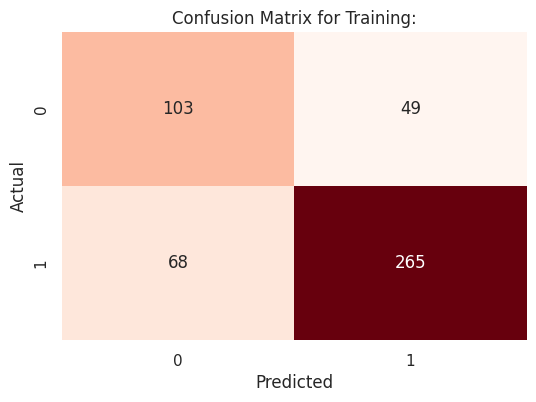

In [63]:
# Get the predicted probabilities for the test set
y_proba = knn.predict_proba(train)[:, 1] 

# Apply the threshold of 0.75
y_pred = (y_proba >= 0.75).astype(int) 

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Training:")
plt.show()

In [64]:
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       152
           1       0.84      0.80      0.82       333

    accuracy                           0.76       485
   macro avg       0.72      0.74      0.73       485
weighted avg       0.77      0.76      0.76       485



Testing

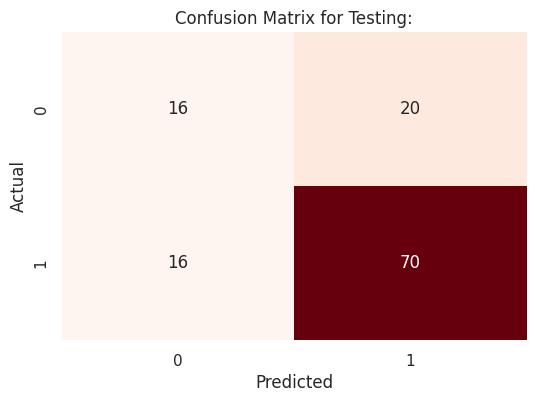

In [65]:
# Get the predicted probabilities for the test set
y_proba = knn.predict_proba(test)[:, 1] 

# Apply the threshold of 0.75
y_pred = (y_proba >= 0.75).astype(int) 
      
# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Reds", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Testing:")
plt.show()

In [66]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.44      0.47        36
           1       0.78      0.81      0.80        86

    accuracy                           0.70       122
   macro avg       0.64      0.63      0.63       122
weighted avg       0.70      0.70      0.70       122



* We Got 0.80 Accuracy By F1 Score Matrix With 0.78 Precision by KNN Model

Let's Try One More Model

## Random Forest Classifier

In [67]:
# Initialize RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Train the RandomForestClassifier with the training data
rfc.fit(train, y_train)

RandomForestClassifier(random_state=42)

In [68]:
# Predict on the train set
y_pred = rfc.predict(train)

# Evaluate the model using confusion matrix and classification report
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00       333

    accuracy                           1.00       485
   macro avg       1.00      1.00      1.00       485
weighted avg       1.00      1.00      1.00       485



In [69]:
# Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples required to be a leaf node
    'max_features': ['sqrt', 'log2']         # Number of features to consider at each split
}

# Initialize GridSearchCV with RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0  # Suppress detailed output
)

# Fit grid search on the training data
grid_search.fit(train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [70]:
# Get the best parameters
best_params = grid_search.best_params_
best_params

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

In [71]:
rfc = RandomForestClassifier(**best_params, random_state=42)
rfc.fit(train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

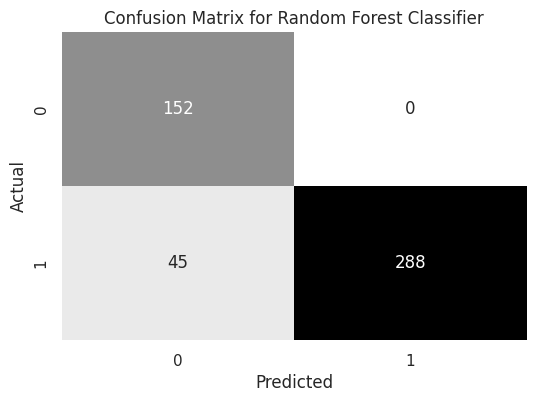

In [72]:
y_proba = rfc.predict_proba(train)[:, 1] 

# Apply the threshold of 0.75
y_pred = (y_proba >= 0.75).astype(int) 

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d", cmap="Greys", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [73]:
# Evaluate the model using classification report
print("Classification Report for Training:")
print(classification_report(y_train, y_pred))

Classification Report for Training:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       152
           1       1.00      0.86      0.93       333

    accuracy                           0.91       485
   macro avg       0.89      0.93      0.90       485
weighted avg       0.93      0.91      0.91       485



Testing

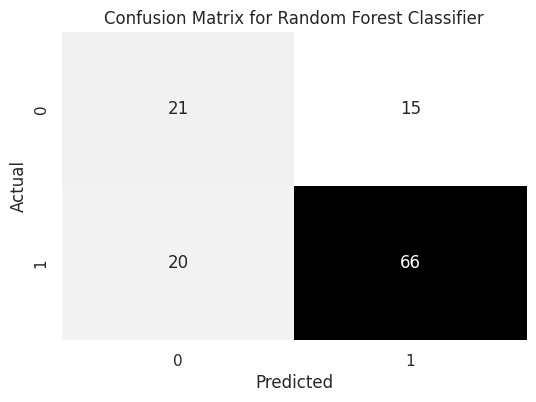

In [74]:
y_proba = rfc.predict_proba(test)[:, 1] 

# Apply the threshold of 0.75
y_pred = (y_proba >= 0.75).astype(int) 

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greys", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

In [75]:
# Evaluate the model using classification report
print("Classification Report for Testing:")
print(classification_report(y_test, y_pred))

Classification Report for Testing:
              precision    recall  f1-score   support

           0       0.51      0.58      0.55        36
           1       0.81      0.77      0.79        86

    accuracy                           0.71       122
   macro avg       0.66      0.68      0.67       122
weighted avg       0.73      0.71      0.72       122



* We Got 0.79 Accuracy By F1 Score Matrix With 0.81 Precision by RFC Model

# Conclusion

* The best performing model is "Support Vector Classifier" with f1 score of 0.91 with 0.85 Precision on training set & f1 score of 0.85 with 0.80 Precision on testing set